# Evaluate the performance of CritterCounter models

We will use this to evaluate the performance of the models on the NACTI validation set.

### Set up the environment

In [1]:
import os 
import pandas as pd
import re
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
import numpy as np
from sklearn.metrics import confusion_matrix

ModuleNotFoundError: No module named 'keras'

## Import the holdout data

### Create the data frame

In [2]:
test_path = '/data/dataframes/speciesTest.csv'
test_df = pd.read_csv(test_path)
test_df['abs_file_path'] = '/data/nacti/' + test_df['file_path']

In [3]:
print(len(test_df))
test_df['category_name'].value_counts().sort_index()

31833


american_black_bear    2500
bobcat                 2500
cougar                 2500
coyote                 2500
domestic_cow           2500
domestic_dog            229
elk                    2500
gray_fox               2500
moose                  2500
mule_deer              2500
red_deer               2500
red_fox                 501
vehicle                2500
white_tailed_deer      2500
wild_turkey            1000
wolf                    103
Name: category_name, dtype: int64

In [4]:
test_df.head()

,category_id,id,image_id,file_path,category_name,subfolder,cam_location,abs_file_path
0,67,c0dbc9c9-d98a-11e8-969f-000d3a71ec1a,WA-Site2_06322.JPG,sub344/WA-Site2_06322.JPG,american_black_bear,sub344,wa-site2,/data/nacti/sub344/WA-Site2_06322.JPG
1,67,c0e85457-d98a-11e8-969f-000d3a71ec1a,WA-Site2_22084.JPG,sub345/WA-Site2_22084.JPG,american_black_bear,sub345,wa-site2,/data/nacti/sub345/WA-Site2_22084.JPG
2,67,c0e854e3-d98a-11e8-969f-000d3a71ec1a,WA-Site2_22224.JPG,sub345/WA-Site2_22224.JPG,american_black_bear,sub345,wa-site2,/data/nacti/sub345/WA-Site2_22224.JPG
3,67,c0e9fb1d-d98a-11e8-969f-000d3a71ec1a,WA-Site2_23854.JPG,sub345/WA-Site2_23854.JPG,american_black_bear,sub345,wa-site2,/data/nacti/sub345/WA-Site2_23854.JPG
4,67,c0f5bfa3-d98a-11e8-969f-000d3a71ec1a,WA-Site2_38380.JPG,sub347/WA-Site2_38380.JPG,american_black_bear,sub347,wa-site2,/data/nacti/sub347/WA-Site2_38380.JPG


## Species Model Evaluation

### Import the pretrained network

In [4]:
img_width, img_height = 224, 224
batch_size = 1
model_path = '/data/ResNet50/ResNet50_20190404_species_weights.h5'

In [5]:
# Define the model
ResNet50 = ResNet50(weights=None, include_top=False, input_shape=(img_width, img_height, 3))
print('Model loaded.')

# build a classifier model to put on top of the convolutional model
model = Sequential()
model.add(ResNet50)
model.add(Flatten(input_shape=model.output_shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='softmax'))

# Load the pretrained weights
model.load_weights(model_path)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model loaded.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               25690368  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                4112      
Total params: 49,282,192
Trainable params: 49,229,072
Non-trainable params: 53,120
______________________________________________________________

## Generator

In [6]:
test_samples = len(test_df)

test_datagen = ImageDataGenerator(rescale=1/255.)

test_generator = test_datagen.flow_from_dataframe(
    test_df, 
    x_col='abs_file_path', 
    y_col ='category_name', 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    shuffle=False,
    class_mode='categorical')

Found 31833 images belonging to 16 classes.


## Run Predictions

In [ ]:
predictions = model.predict_generator(
    test_generator, 
    steps=test_samples//batch_size,
    verbose=True
)

17760/31833 [===============>..............] - ETA: 17:40

In [8]:
# Save results
np.save(file='/data/results/ResNet50_nacti_species_preds.npy', arr=predictions)

# Evaluation

## Build Results DataFrame

In [9]:
predictions.shape

(31833, 16)

In [10]:
test_df['category_name'].value_counts()

mule_deer              2500
coyote                 2500
vehicle                2500
white_tailed_deer      2500
red_deer               2500
elk                    2500
bobcat                 2500
domestic_cow           2500
moose                  2500
american_black_bear    2500
gray_fox               2500
cougar                 2500
wild_turkey            1000
red_fox                 501
domestic_dog            229
wolf                    103
Name: category_name, dtype: int64

In [11]:
id_map = {
    0: 'american_black_bear',
    1: 'bobcat',
    2: 'cougar',
    3: 'coyote',
    4: 'domestic_cow',
    5: 'domestic_dog',
    6: 'elk',
    7: 'gray_fox',
    8: 'moose',
    9: 'mule_deer',
    10: 'red_deer',
    11: 'red_fox',
    12: 'vehicle',
    13: 'white_tailed_deer',
    14: 'wild_turkey',
    15: 'wolf'
}

In [46]:
preds = pd.DataFrame(predictions)
results_df = pd.concat([test_df.reset_index(drop=True), preds], axis=1)
results_df['top_class'] = pd.Series(predictions.argmax(axis=1))
results_df['top_prob'] = pd.Series(predictions.max(axis=1))
results_df['pred_category_name'] = results_df['top_class'].apply(lambda x: id_map[x])
results_df['top_1_acc'] = results_df['category_name'] == results_df['pred_category_name']

results_df['top_3_classes'] = pd.Series([list(i) for i in predictions.argsort(axis=1)[:,:-4:-1]])
results_df['top_3_classes'] = results_df['top_3_classes'].apply(lambda x: [id_map[i] for i in x])
results_df['top_3_acc'] = results_df.apply(lambda x: x['category_name'] in x['top_3_classes'], axis=1)

results_df['top_5_classes'] = pd.Series([list(i) for i in predictions.argsort(axis=1)[:,:-6:-1]])
results_df['top_5_classes'] = results_df['top_5_classes'].apply(lambda x: [id_map[i] for i in x])
results_df['top_5_acc'] = results_df.apply(lambda x: x['category_name'] in x['top_5_classes'], axis=1)

In [48]:
results_df.to_csv('/data/results/ResNet50_nacti_species_results.csv', index=False)

## Evaluation Metrics

In [20]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, precision_recall_curve
import seaborn as sns; sns.set()

In [21]:
print('Top 1 Accuracy: {:.2%}'.format(results_df['top_1_acc'].mean()))
print('Top 3 Accuracy: {:.2%}'.format(results_df['top_3_acc'].mean()))
print('Top 5 Accuracy: {:.2%}'.format(results_df['top_5_acc'].mean()))
print('F1 Score: {:.2%}'.format(f1_score(results_df['category_name'], results_df['pred_category_name'], average='weighted')))
print('Precision Score: {:.2%}'.format(precision_score(results_df['category_name'], results_df['pred_category_name'], average='weighted')))
print('Recall Score: {:.2%}'.format(recall_score(results_df['category_name'], results_df['pred_category_name'], average='weighted')))


Top 1 Accuracy: 83.01%
Top 3 Accuracy: 95.60%
Top 5 Accuracy: 98.38%
F1 Score: 83.20%
Precision Score: 84.09%
Recall Score: 83.01%


## Categorical Breakdown

In [22]:
results_df.groupby('category_name')['top_1_acc'].mean()*100

category_name
american_black_bear    91.560000
bobcat                 86.600000
cougar                 81.680000
coyote                 67.280000
domestic_cow           91.400000
domestic_dog           51.528384
elk                    90.920000
gray_fox               90.000000
moose                  69.320000
mule_deer              83.440000
red_deer               73.880000
red_fox                63.273453
vehicle                90.120000
white_tailed_deer      95.040000
wild_turkey            66.100000
wolf                   45.631068
Name: top_1_acc, dtype: float64

In [36]:
results_df.groupby(['cam_location', 'pred_category_name'])['file_path'].count()

cam_location          pred_category_name 
2010_unit151_ivan033  american_black_bear       1
                      coyote                   10
                      domestic_dog              5
                      mule_deer                80
                      red_deer                 34
                      red_fox                   4
                      vehicle                   1
                      wild_turkey               1
2010_unit155_ivan015  mule_deer                21
                      red_deer                 33
2010_unit156_ivan057  coyote                   15
                      mule_deer                10
                      red_fox                   3
2010_unit156_ivan058  coyote                    6
                      moose                     1
                      mule_deer                11
                      red_deer                 11
                      red_fox                   2
2010_unit156_ivan063  american_black_bear       2
        

In [35]:
results_df.groupby(['cam_location', 'category_name'])['file_path'].count()

cam_location                category_name      
2010_unit151_ivan033        american_black_bear       2
                            coyote                    7
                            mule_deer               100
                            red_deer                 23
                            red_fox                   4
2010_unit155_ivan015        coyote                    3
                            mule_deer                 4
                            red_deer                 47
2010_unit156_ivan057        coyote                   13
                            mule_deer                10
                            red_fox                   5
2010_unit156_ivan058        coyote                    9
                            mule_deer                12
                            red_deer                  8
                            red_fox                   2
2010_unit156_ivan063        american_black_bear       1
                            mule_deer                10


In [32]:
results_df.groupby('cam_location')['pred_category_name'].nunique().mean()

4.6177777777777775

In [28]:
animal_df = results_df[results_df['category_name'].isin(['wolf', 'domestic_dog'])]

In [29]:
animal_df.groupby(['category_name', 'pred_category_name'])['file_path'].count().reset_index(drop=False)

,category_name,pred_category_name,file_path
0,domestic_dog,american_black_bear,6
1,domestic_dog,coyote,8
2,domestic_dog,domestic_dog,118
3,domestic_dog,moose,4
4,domestic_dog,mule_deer,76
5,domestic_dog,red_deer,4
6,domestic_dog,red_fox,11
7,domestic_dog,wild_turkey,2
8,wolf,american_black_bear,6
9,wolf,cougar,18


In [40]:
conf_mat = confusion_matrix(results_df['category_name'], results_df['pred_category_name'])
pd.DataFrame(np.round(conf_mat/np.repeat(conf_mat.sum(axis=1), 16).reshape(16,16), 2))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.92,0.01,0.00,0.01,0.01,0.03,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.87,0.02,0.06,0.02,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.01,0.10,0.82,0.01,0.02,0.00,0.01,0.02,0.00,0.01,0.00,0.00,0.00,0.00,0.01,0.00
3,0.04,0.07,0.01,0.67,0.01,0.00,0.00,0.02,0.01,0.06,0.00,0.08,0.00,0.00,0.01,0.00
4,0.01,0.02,0.01,0.02,0.91,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00
5,0.03,0.00,0.00,0.03,0.00,0.52,0.00,0.00,0.02,0.33,0.02,0.05,0.00,0.00,0.01,0.00
6,0.01,0.01,0.01,0.00,0.05,0.00,0.91,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.06,0.01,0.02,0.00,0.00,0.00,0.90,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.03,0.00,0.00,0.05,0.00,0.01,0.00,0.00,0.69,0.07,0.14,0.01,0.00,0.00,0.00,0.00
9,0.00,0.00,0.01,0.03,0.00,0.02,0.00,0.00,0.02,0.83,0.07,0.01,0.00,0.00,0.01,0.00


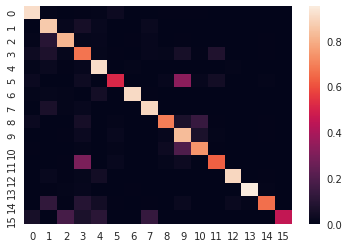

In [44]:
sns.heatmap(conf_mat/np.repeat(conf_mat.sum(axis=1), 16).reshape(16,16))